# Gaussian process classification

[Section 2](02-gaussian_process_regression.ipynb) introduced how we can use Gaussian processes for regression when we assumed normally distributed data. In that scenario derivation of the posterior GP was especially easy, because it has a closed form solution.

In this section we will extend the GP framework with classification of data consisting of two groups, where we use most material from [Rasmussen and Williams (2006)](http://www.gaussianprocess.org/gpml/).

We will again use `GPy` and `scipy` for demonstration.

As usual **I do not take warranty for the correctness or completeness of this document.**

In [31]:
import GPy
import scipy
from sklearn.metrics.pairwise import rbf_kernel
from scipy.special import expit
from scipy.stats import bernoulli 

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 6]

N = 5
base = plt.cm.get_cmap("viridis")
color_list = base(scipy.linspace(0, 1, N))

In [32]:
rnorm = scipy.stats.norm.rvs
mvrnorm = scipy.stats.multivariate_normal.rvs

###  GP prior

For classification we will still use a Gaussian process prior, even though our data is not Gaussian:

\begin{align*}
f(\mathbf{x}) & \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')) ,\\
p(f \mid \mathbf{x}) & = \mathcal{N}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')),
\end{align*}

where $m$ is again the mean function and $k$ is a *kernel function* $k$ is a psd kernel with respective hyperparameters.

For classification we will a data set $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$ with $y_i \in \{0, 1\}$.

Consequently, we need to *squash* a **latent** sample of the GP prior through a logistic function to receive a prior on the probabilities $\pi(\mathbf{x})$, i.e. the expeted values of $y_i$;

\begin{equation}
\pi(x) = \frac{1}{1+\exp(-x)}
\end{equation}

Let's visualize some prior samples $\pi(\cdot)$. First we generate some data:

In [33]:
scipy.random.seed(23)

n = 50
x = scipy.linspace(0, 1, n).reshape((n, 1))
beta = 2
z = expit(scipy.sin(x) * beta)
y = scipy.zeros(n)
y[int(n/2):] = 1

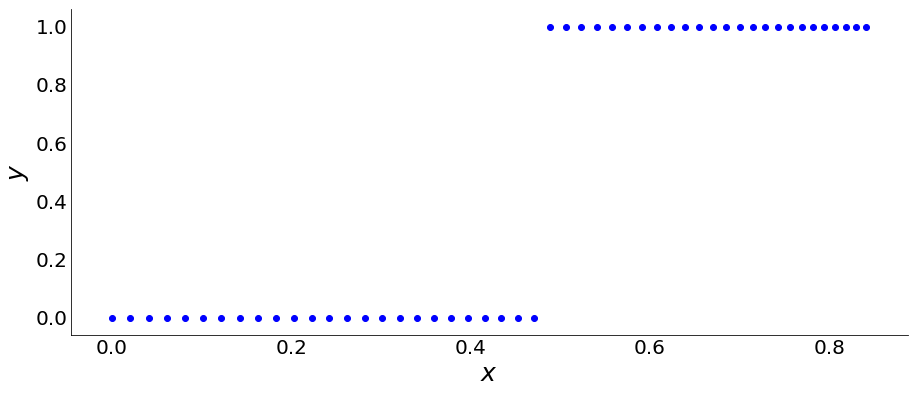

In [34]:
_, ax = plt.subplots()
ax.scatter(scipy.sin(x), y, color="blue")
plt.xlabel("$x$", fontsize=25)
plt.ylabel("$y$", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(length=0, color="black")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

Then we define the kernel and likelihood:

In [160]:
m = scipy.zeros(n)
kernel = GPy.kern.RBF(input_dim=1)

k = kernel.K(x, x)
lik = GPy.likelihoods.Bernoulli()

Finally, we sample some prior values. First we generate a sample from the latent GP. Then we transform these values using the sigmoid function. In the end we binarize the outcome of the last step.

In [36]:
f_prior = mvrnorm(mean=m, cov=k)
p_prior = lik.gp_link.transf(f_prior)
y_prior = lik.samples(f_prior).reshape(-1,1) 

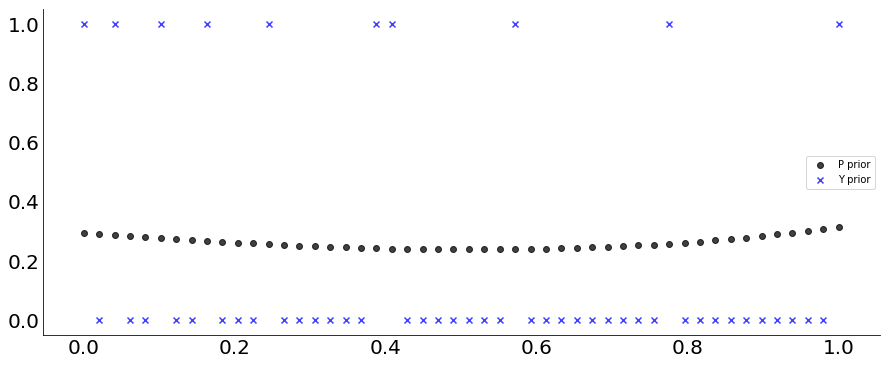

In [37]:
_, ax = plt.subplots()
ax.scatter(x, p_prior, color="k", marker="o", alpha=0.75, label="P prior")
ax.scatter(x, y_prior, color="blue", marker="x", alpha=0.75, label="Y prior")
ax.spines['top'].set_visible(Fbalse)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(length=0, color="black")
plt.legend()
plt.show()

This is of course fairly random, so our prior guess is pretty off charts.

### GP posterior

We will use a binomial likelihood for constructing the posterior:

\begin{align*}
p(\mathbf{y} \mid f, \mathbf{x}) = \prod_i^n \mathcal{Bernoulli}\left(\text{logit}^{-1} \left(f \right) \right),
\end{align*}

where we used a *logit link function*. The inverse of the $\text{logit}$ is the well-known $\text{logistic}$ function which we already defined above. We will call the inverse of the link function the *mean function*. The necessity of a mean function is the same as in GLMs: relating the expected value of the response to the predictor.

The posterior Gaussian process is then given by:

\begin{align*}
\text{posterior} & \propto \text{likelihood} \times \text{prior},\\
p(f \mid \mathbf{y}, \mathbf{x}) & \propto p(\mathbf{y} \mid f, \mathbf{x}) \ p(f \mid \mathbf{x}).
\end{align*}

Since the prior is not conjugate to the likelihood, the posterior does not have an analytical form and thus needs to bei either approximated deterministically, e.g using Laplace's approximation, expectation propagation or variationally, or stochastically using sampling. I'll go over two different approaches:

- the Laplace approximation (which is one of the typical textbook examples),
- a Markov Chain Monte Carlo sampler.

#### Laplace approximation to the posterior

Since the Gaussian process prior distribution is multivariate Gaussian, the posterior is often also fairly close to a multivariate Gaussian, unimodal and roughly symmetric. Note that this implies that for more complex likelihoods the normal approximation should be a fairly bad choice.

We shall use a Taylor expansion around the mode $\bar{f} $ of the log-posterior $\log p(f \mid \mathbf{y}, \mathbf{x})$, i.e.

\begin{align*}
\log p(f \mid \mathbf{y}, \mathbf{x}) = & \ \underbrace{\log p(\bar{f} \mid \mathbf{y}, \mathbf{x})}_{\text{constant}} \\ 
& + \underbrace{(f - \bar{f}) \left[ \frac{\partial  }{\partial f} \log p({f} \mid \mathbf{y}, \mathbf{x})  \right]_{\mid \;f = \bar{f}}}_{0} \\
& + \frac{1}{2}(f - \bar{f})^T \left[ \frac{\partial^2 }{\partial f^2} \log p({f} \mid \mathbf{y}, \mathbf{x})  \right]_{\mid \;f = \bar{f}}(f - \bar{f}) \\
& + \dots
\end{align*}

The first line is a constant in the mode $\bar{f}$. The first partial derivative evaluated at $f = \bar{f}$ is zero, because it is the mode of the function, so we can safely omit it. The other higher order derivatives can also be omitted due to the fact that they have less relative importance for large $n$. So let's take a closer look at the second partial derivative. We observe that

\begin{align*}
\frac{1}{2}(f - \bar{f})^T \left[ \frac{\partial^2 }{\partial f^2} \log p({f} \mid \mathbf{y}, \mathbf{x})  \right]_{\mid \;f = \bar{f}}(f - \bar{f})
\end{align*}

is proportional to the exponent of a multivariate normal distribution with mean $\boldsymbol \mu = \bar{f}$ and variance $\boldsymbol  \Sigma = \left( - \frac{\partial^2 }{\partial f^2} \log p({f} \mid \mathbf{y}, \mathbf{x})\right)^{-1} $. So we use this to approximate the posterior as:

\begin{align*}
p(f \mid \mathbf{y}, \mathbf{x}) & \approx q(f \mid \mathbf{x}, \mathbf{y}) \\
& = \mathcal{N}\left(\bar{f} , \left( - \frac{\partial^2 }{\partial f^2} \log p({f} \mid \mathbf{y}, \mathbf{x})  \right)^{-1}\right).
\end{align*}

In order to find the mode $\bar{f}$ of the posterior $p(f \mid \mathbf{y}, \mathbf{x})$, we need to maximize it (or its logarithm):

\begin{align*}
\log p(f \mid \mathbf{y}, \mathbf{x}) = \log p(\mathbf{y} \mid f, \mathbf{x}) + \log p(f \mid \mathbf{x}) - \log(\mathbf{y} \mid \mathbf{x}).
\end{align*}

Maximizing the posterior w.r.t. $f$ is independent of the marginal likelihood, so it suffices to maximize

\begin{align*}
\Psi(f) = \log p(\mathbf{y} \mid f, \mathbf{x}) + \log p(f \mid \mathbf{x}).
\end{align*}

We can optimze this using a standard gradient based solver, but since we need the Hessian matrix anyways for the variance of the normal approximation, it makes sense to use Newton's method.

The Jacobian and Hessian of $\Psi(f)$ are given by:

\begin{align*}
\frac{\partial }{\partial f} \Psi &= \frac{\partial}{\partial f} \log p(\mathbf{y} \mid f, \mathbf{x}) - k(\mathbf{x}, \mathbf{x}')^{-1}f,\\
\frac{\partial^2 }{\partial f^2}\Psi & = \frac{\partial^2}{\partial f^2}  \log p(\mathbf{y}\mid f, \mathbf{x}) -k(\mathbf{x}, \mathbf{x}')^{-1},
\end{align*}

where the Hessian of the likelihood depends on the choice of the mean function. As above we will usea logistic mean function, and define a matrix $\mathbf{W}$ as the negative Hessian:

\begin{align*}
\mathbf{W} & = - \frac{\partial^2}{\partial f^2}  \log p(\mathbf{y}\mid f, \mathbf{x}) \\ & =  \operatorname{diag}(\sigma_1(1 - \sigma_1), \dots,  \sigma_n(1 - \sigma_n))
\end{align*}

Having laid the ground-work, we update $\bar{f}$ in every iteration of Newton's method as:

\begin{align*}
\bar{f}_{t + 1} & = \bar{f}_{t} - (\nabla \nabla \Psi)^{-1} \nabla \Psi\\
& = (k(\mathbf{x}, \mathbf{x}')^{-1} + \mathbf{W})^{-1}\left(\mathbf{W}f + \nabla \log p(\mathbf{y} \mid f, \mathbf{x})\right)
\end{align*}

Having solved this for $\bar{f}$, the approximate posterior is given as:

\begin{align*}
q(f \mid \mathbf{y}, \mathbf{x}) = \mathcal{N}(\bar{f}, \frac{\partial^2}{\partial f^2}  \log p(\mathbf{y}\mid f, \mathbf{x}) -k(\mathbf{x}, \mathbf{x}')^{-1} ),
\end{align*}

The implementation is fairly straight-forward, so we won't do that here. If you want to see a solution in R, you can for instance look at some [of my code](https://github.com/dirmeier/GPy).

Let's again demostrate this using `GPy`. First we set the model and the inference method of our choice: the Laplace approximation as explained above. For convenience we redefine the kernel and likelihood from above.

In [49]:
m = GPy.core.GP(X = x.reshape((n, 1)),
                Y = y.reshape((n, 1)), 
                kernel = GPy.kern.RBF(input_dim=1), 
                inference_method = GPy.inference.latent_function_inference.Laplace(),
                likelihood = GPy.likelihoods.Bernoulli())
m.optimize()

Then we plot the data and the mean posterior process.

 /Users/simondi/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


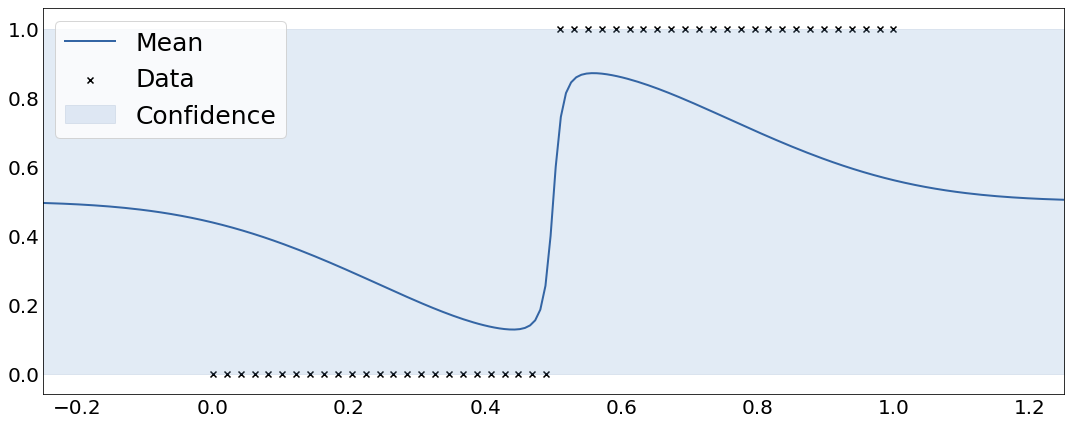

In [155]:
m.plot()
plt.tick_params(axis='both', which='major', labelsize=20)
plt.tick_params(length=0, color="black")
plt.legend(fontsize=25)
plt.show()

#### Laplace approximation of the posterior predictive

Using the approximation of the posterior, we can calculate the predictive distribution of the latent variable $f^*$ for new data ${x}^*$:

\begin{align}
q(f^* \mid x^*, \mathbf{x}, \mathbf{y}) & = \int p(f^* \mid {x}^*, \mathbf{x}, {f}) q({f} \mid \mathbf{x}, \mathbf{y})d{f} \\
\mathbb{E}[f^* \mid x^*, \mathbf{x}, \mathbf{y}] & =  \kappa({x}^*, \mathbf{x} )(\mathbf{y} -  \sigma(\bar{{f}})) \\
\mathbb{V}[f^* \mid x^*, \mathbf{x}, \mathbf{y}] & =  \kappa({x}^*, {x}^*) - \kappa({x}^*, \mathbf{x} ) (\mathbf{K} + \mathbf{W}^{-1} )^{-1}  \kappa(\mathbf{x}, {x}^*)
\end{align}

The class of a novel data-point $y^*$ is then calculated as:

\begin{align}
P(y^* = 1 \mid x^*, \mathbf{x}, \mathbf{y}) & = \int \sigma(y^*) q(f^* \mid x^*, \mathbf{x}, \mathbf{y}) d f^* \\
& =   \int \sigma(y^*) \mathcal{N}(\mathbb{E}[f^*], \mathbb{V}[f^*]  ) d f^*,
\end{align}

which can be calculated using the Gaussian error function.

Prediction is fairly simple using `GPy`. We just plugin some new data into the `predict` function of the GP.

In [156]:
x_new = rnorm(size=(100, 1))
y_hat = m.predict(x_new)[0].reshape((100, 1))

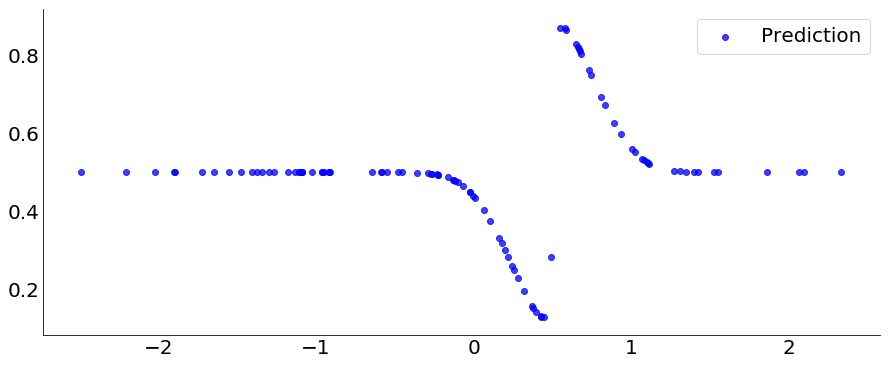

In [157]:
_, ax = plt.subplots()
ax.scatter(x_new, y_hat, color="blue", alpha=0.75, label="Prediction")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(length=0, color="black")
plt.legend(fontsize=20)
plt.show()

#### Metropolis-hastings sampling

In [ ]:
# TODO